### Visualize how factor is applied

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
from functools import reduce

import matplotlib.pyplot as plt

In [2]:
LOGS_DIR = "/home/tomasmizera/school/diploma/src/data/experiments/fp-precomputed-v3/latest/csv/"
LOGS2_DIR = "/home/tomasmizera/school/diploma/src/data/experiments/fp-precomputed-v3continue/latest/csv/"

In [3]:
def _read_text_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        return reduce(lambda a, b: a+b, lines, '')

def load_files(path_to_files):
    
    files_it = os.scandir(path_to_files)
    files_contents = {}
    
    for file in files_it:
        if file.is_file() and file.name.startswith('fm-'):
            factor = file.name.replace('fm-', '')
            factor = factor.replace('.csv', '')
            files_contents[int(factor)] = _read_text_file(file.path)
        
    return dict(sorted(files_contents.items()))

In [4]:
file_contents = load_files(LOGS_DIR)
file_contents2 = load_files(LOGS2_DIR)

In [5]:
content = {**file_contents, **file_contents2}

In [6]:
# 1. build dataframe from each

dfs = {}

for item in content.items():
    factor = item[0]
    c = StringIO(item[1])
    df = pd.read_csv(c, delimiter=',')
    dfs[factor] = df

In [7]:
# Normalize values to custom bounds https://stackoverflow.com/a/48109733/7875594
def normalize(values, bounds):
    if bounds['actual']['upper'] == bounds['actual']['lower']:
        return values
    return [bounds['desired']['lower'] + (abs(x) - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / 
            (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]


def process_mean(df):
    df = df.reset_index(drop=True)
    
    df['difSimple'] = df.originalP - df.simpleSP
    df['difCustom'] = df.originalP - df.customSP
    return df.difCustom.mean(), df.difSimple.mean()


def process_mse(df, maxval, minval):
    """
    From input dataframe returns 2 MSE errors: (1) error from custom summaries, (2) error from simple summaries
    """
    
    df = df.reset_index(drop=True)
    
    # 1. normalize to (-1, 1)
    bounds = {'actual': {'lower':minval, 'upper':maxval}, 'desired':{'lower':-1, 'upper':1}}
    df['normOriginal'] = normalize(df.originalP, bounds)
    df['normCustom'] = normalize(df.customSP, bounds)
    df['normTextRank'] = normalize(df.simpleSP, bounds)
    
    # 2. subtract textrank and custom predictions from model prediction on entire instance to get errors
    df['errorTextRank'] = df.normOriginal - df.normTextRank
    df['errorCustom'] = df.normOriginal - df.normCustom
    
    # 3. square errors
    df['errorTextRank'] = df.errorTextRank ** 2
    df['errorCustom'] = df.errorCustom ** 2
    
    # 4. find mean
    arr = np.array([df.errorCustom.mean(), df.errorTextRank.mean()])
    
    # 5. square root errors
    arr = np.sqrt(arr)
    
    return arr[0], arr[1]
    
    # squareroot
    # mean of that
    return df.difCustom.mean(), df.difSimple.mean()

def process_arr(dfs, error_func):
    data = {}
    
    mmin = 1
    mmax = 0
    # first max and min prediction across all predictions
    for d in dfs.items():
        ma = max(d[1].originalP.max(),
                 d[1].customSP.max(),
                 d[1].simpleSP.max()
                )
        mi = min(d[1].originalP.min(),
                 d[1].customSP.min(),
                 d[1].simpleSP.min()
                )
        if mi < mmin:
            mmin = mi
        if ma > mmax:
            mmax = ma
    
    
    for d in dfs.items():
        ix = d[0]
        if error_func == 'mse':
            data[int(ix)] = process_mse(d[1], mmax, mmin)
        elif error_func == 'mean':
            data[int(ix)] = process_mean(d[1])
    return data


In [8]:
processed_mean = process_arr(dfs, 'mean')
processed_mse = process_arr(dfs, 'mse')

### MSE

In [9]:
pdf = pd.DataFrame(processed_mse).T
pdf = pdf.rename({0:'custom', 1:'textrank'}, axis=1)
pdf = pdf.sort_index()
pdf.tail()

,custom,textrank
6504,0.452239,0.469905
7155,0.452239,0.469905
7871,0.452239,0.469905
8659,0.452239,0.469905
9525,0.452239,0.469905


In [10]:
last_change_fm = pdf.loc[np.isclose(pdf.custom,pdf.custom.unique()[-1])].index[0]

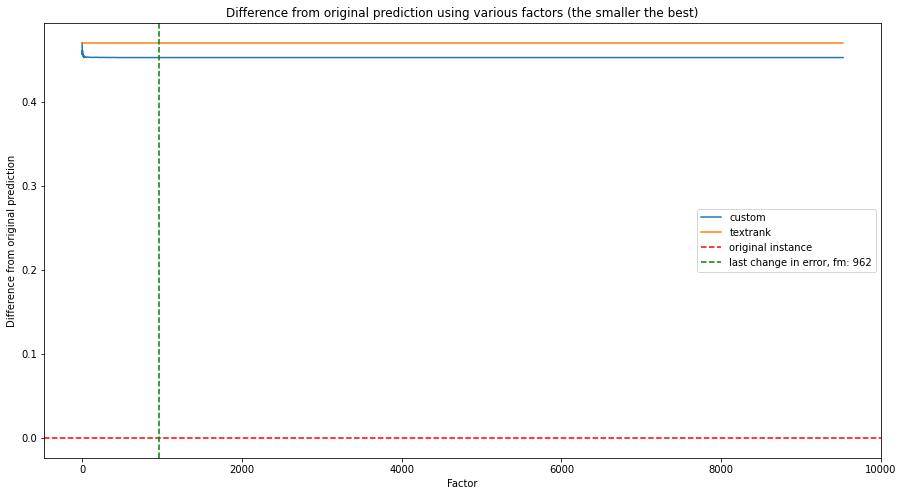

In [11]:
ax = pdf.plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

ax.axhline(y=0, color='r', linestyle='--', label='original instance');
ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));

plt.legend()
plt.show()

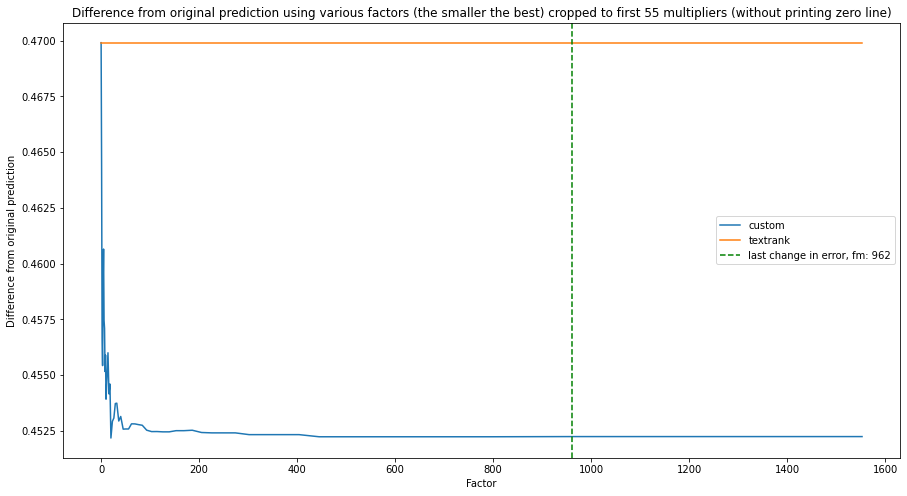

In [12]:
ax = pdf[:55].plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best) cropped to first 55 multipliers (without printing zero line)"
);

# ax.axhline(y=0, color='r', linestyle='--', label='vline1.5custom');
ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));

plt.legend()
plt.show()

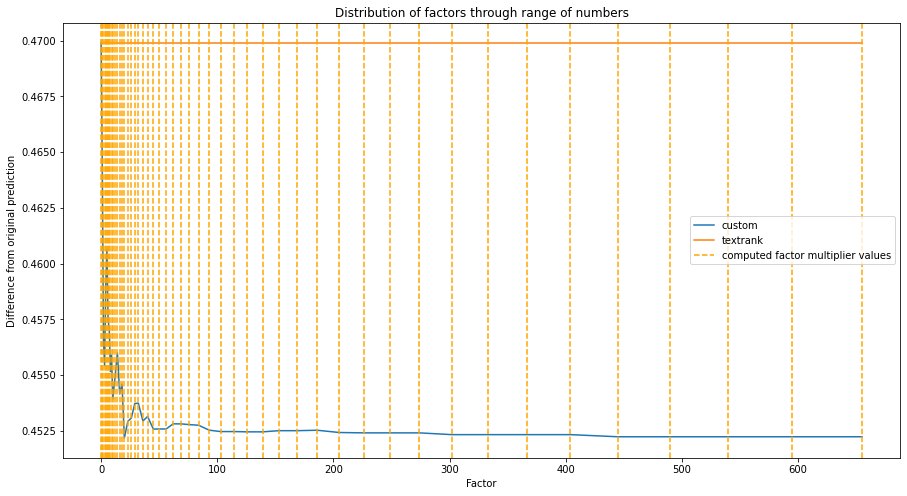

In [13]:
ax = pdf[:50].plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Distribution of factors through range of numbers"
);

for i in range(50):
    l = ax.axvline(x=pdf.iloc[i].name, color='orange', linestyle='--');

l.set_label('computed factor multiplier values')
plt.legend()
plt.show()

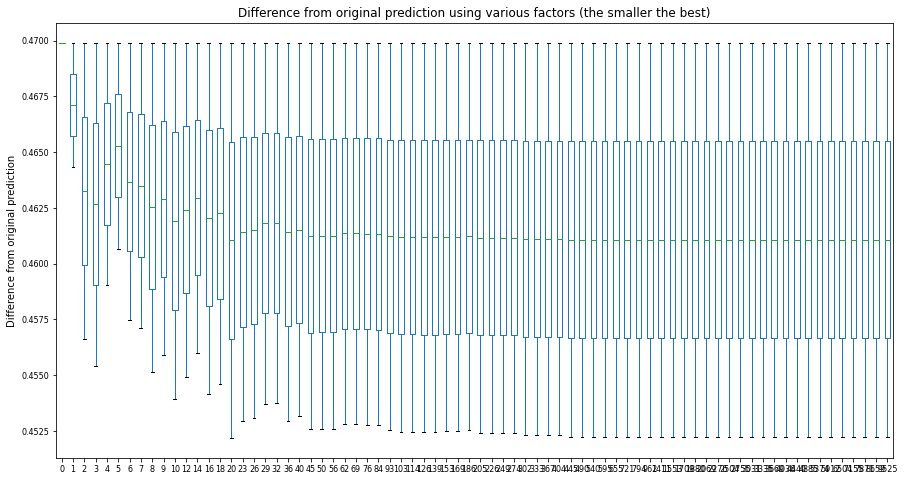

In [14]:
pdf.T.plot.box(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=8, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

<AxesSubplot:>

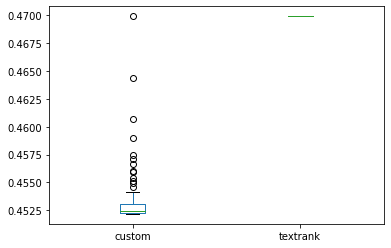

In [15]:
pdf.plot.box()

In [16]:
pdf.describe()

,custom,textrank
count,74.000000,7.400000e+01
mean,0.453505,4.699049e-01
std,0.002869,1.117801e-16
min,0.452174,4.699049e-01
25%,0.452239,4.699049e-01
50%,0.452414,4.699049e-01
75%,0.453037,4.699049e-01
max,0.469905,4.699049e-01


### Mean

In [17]:
pdfm = pd.DataFrame(processed_mean).T
pdfm = pdfm.rename({0:'custom', 1:'textrank'}, axis=1)
pdfm = pdfm.sort_index()
pdfm.tail()

,custom,textrank
6504,-0.003525,-0.005502
7155,-0.003525,-0.005502
7871,-0.003525,-0.005502
8659,-0.003525,-0.005502
9525,-0.003525,-0.005502


In [18]:
last_change_fm = pdfm.loc[np.isclose(pdfm.custom,pdfm.custom.unique()[-1])].index[0]

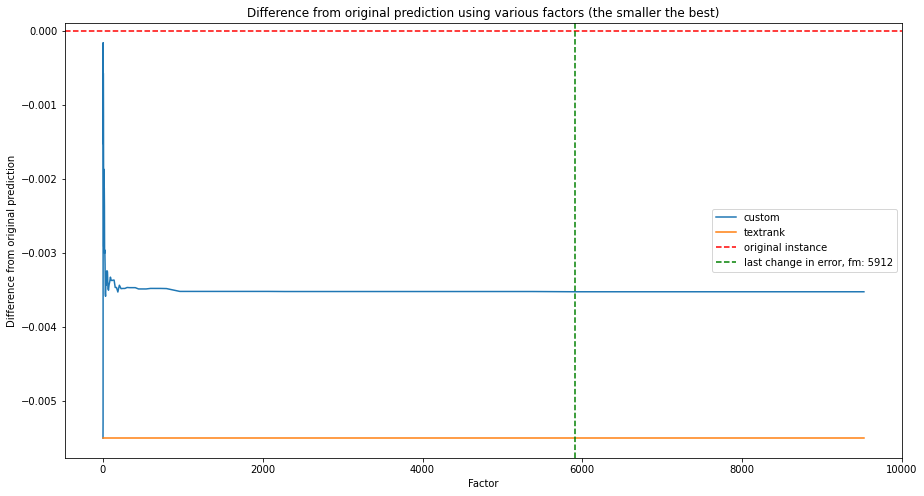

In [19]:
ax = pdfm.plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

ax.axhline(y=0, color='r', linestyle='--', label='original instance');
ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));

plt.legend()
plt.show()

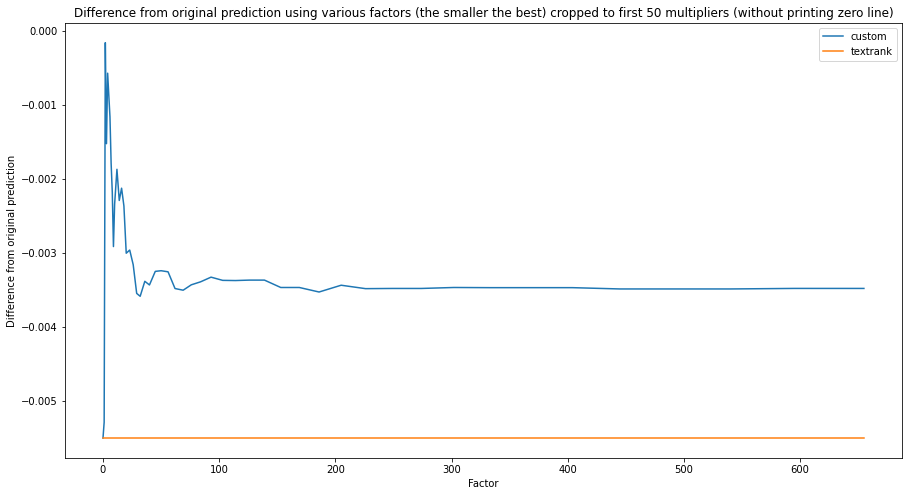

In [20]:
ax = pdfm[:50].plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best) cropped to first 50 multipliers (without printing zero line)"
);

# ax.axhline(y=0, color='r', linestyle='--', label='vline1.5custom');
# ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));

plt.legend()
plt.show()

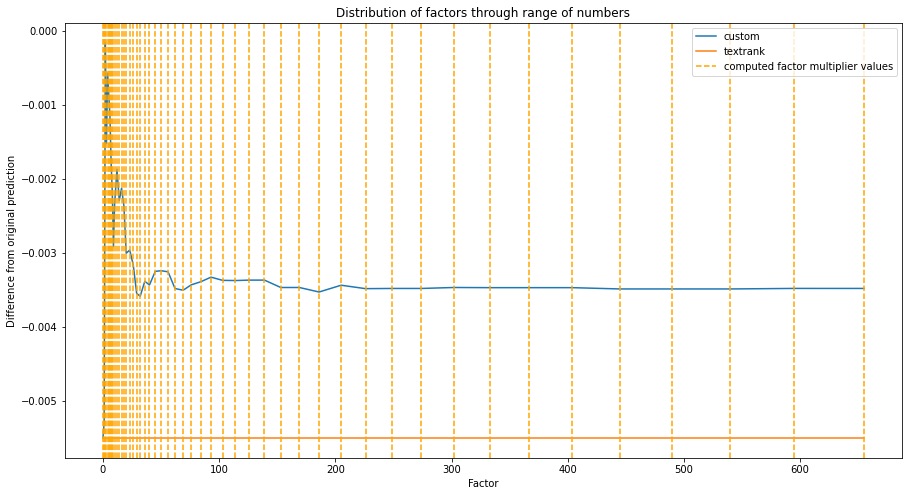

In [21]:
ax = pdfm[:50].plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Distribution of factors through range of numbers"
);

for i in range(50):
    l = ax.axvline(x=pdfm.iloc[i].name, color='orange', linestyle='--');

l.set_label('computed factor multiplier values')
plt.legend()
plt.show()

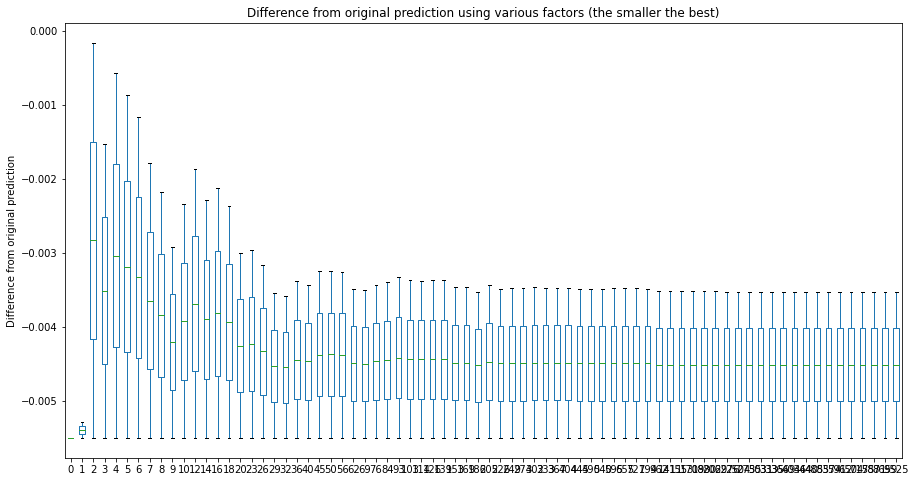

In [22]:
pdfm.T.plot.box(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

<AxesSubplot:>

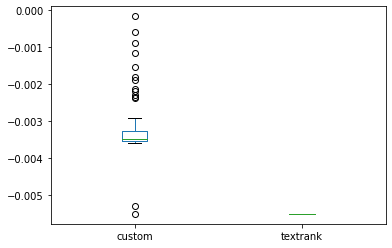

In [23]:
pdfm.plot.box()

In [24]:
pdfm.describe()

,custom,textrank
count,74.000000,74.000000
mean,-0.003195,-0.005502
std,0.000836,0.000000
min,-0.005502,-0.005502
25%,-0.003522,-0.005502
50%,-0.003480,-0.005502
75%,-0.003273,-0.005502
max,-0.000158,-0.005502


---
---
---

**Final factor: 595**